## FaceNet Distance Test

In [1]:
from google.colab import output
#@markdown ## Clone git repository(please do not run this cell more than one)
!git clone https://github.com/junia3/FaceBlurring.git

Cloning into 'FaceBlurring'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 210 (delta 8), reused 2 (delta 2), pack-reused 199
Receiving objects: 100% (210/210), 65.35 MiB | 11.78 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [2]:
# Install requirements
!pip install facenet_pytorch
!pip install -U Cython cmake numpy
!pip install onnxruntime
!pip install -U insightface
output.clear()

In [3]:
# Make directory to get sample data 
%cd '/content/FaceBlurring/data/'
!mkdir -p 'sample_root/clean/'
%cd 'sample_root/clean/'

/content/FaceBlurring/data
/content/FaceBlurring/data/sample_root/clean


In [4]:
# Download sample data and unzip to data directory
!gdown https://drive.google.com/uc?id=1jonSjJhywVMYHel3u8XNUQH684VyneWf
!unzip -o sample.zip
!rm sample.zip
output.clear()

In [5]:
!pip install -U Cython cmake numpy
!pip install onnxruntime-gpu
!pip install -U insightface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111.0 MB 38 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# generate blur data with samples(It takes some time)
%cd '/content/FaceBlurring/dataset/'
!python create_blurimg.py --blur defocus --save True --label True

/content/FaceBlurring/dataset
Check all sample images(clean)...
4it [00:00, 2671.11it/s]
Create sample directories...
100% 427/427 [00:00<00:00, 80014.65it/s]
download_path: /root/.insightface/models/buffalo_l
100% 281857/281857 [04:34<00:00, 1027.23KB/s]
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_use_max_workspace': '0', 'enable_cuda_graph': '0', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_external_empty_cache': '0', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0'}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_use_max_workspace

# Embedding test with FaceNet

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import numpy as np

## Distance, Cosine similarity

In [8]:
def L1_distance(emb1, emb2):
    return torch.abs(torch.sum(emb1 - emb2))

def L2_distance(emb1, emb2):
    return torch.sqrt(torch.sum(torch.square(emb1 - emb2)))

def cos_sim(A, B):
    return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

## Get clean and blur image to compare (Sample 1)

In [9]:
from dataset import FaceDataset
face_dataset_blur = FaceDataset("../config/test.txt", 'blur')
face_dataset_clean = FaceDataset("../config/test.txt", 'clean')

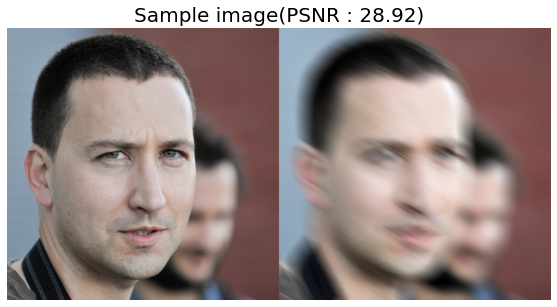

In [10]:
import matplotlib.pyplot as plt
clean_img_sample, _ = face_dataset_clean[0]
blur_img_sample, blur_img_psnr = face_dataset_blur[0]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [11]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [12]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [13]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 2.810047
L2 distance : 0.977717
Cosine similarity : 0.522035


## Sample 2

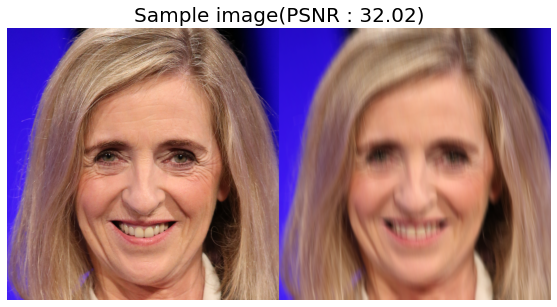

In [14]:
clean_img_sample, _ = face_dataset_clean[23]
blur_img_sample, blur_img_psnr = face_dataset_blur[23]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [15]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [16]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [17]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 1.836671
L2 distance : 0.927947
Cosine similarity : 0.569457


## Sample 3

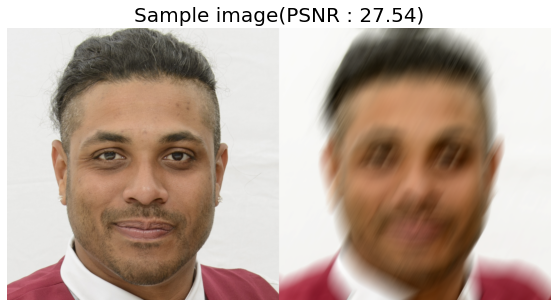

In [18]:
clean_img_sample, _ = face_dataset_clean[48]
blur_img_sample, blur_img_psnr = face_dataset_blur[48]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [19]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [20]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [21]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 2.374443
L2 distance : 1.146279
Cosine similarity : 0.343022


## Sample 4

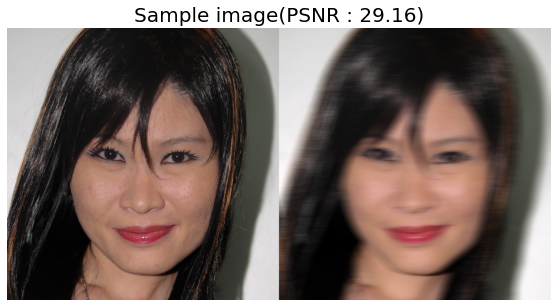

In [22]:
clean_img_sample, _ = face_dataset_clean[52]
blur_img_sample, blur_img_psnr = face_dataset_blur[52]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [23]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [24]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [25]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 2.429225
L2 distance : 0.937517
Cosine similarity : 0.560531


## Sample 5

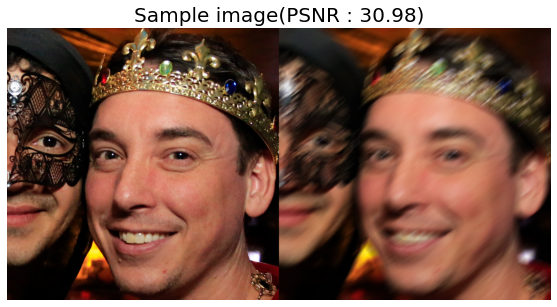

In [26]:
clean_img_sample, _ = face_dataset_clean[17]
blur_img_sample, blur_img_psnr = face_dataset_blur[17]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [27]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [28]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [29]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 0.418429
L2 distance : 0.572513
Cosine similarity : 0.836115


## Sample 6

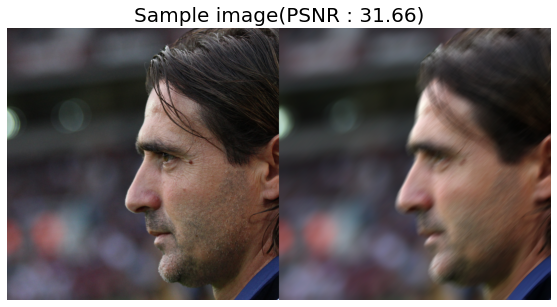

In [33]:
clean_img_sample, _ = face_dataset_clean[8]
blur_img_sample, blur_img_psnr = face_dataset_blur[8]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [35]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [36]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [37]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 1.354749
L2 distance : 0.791196
Cosine similarity : 0.687004


## Sample 7

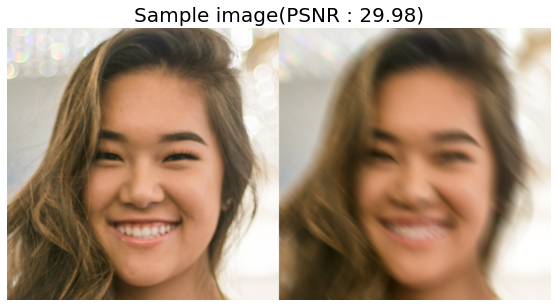

In [38]:
clean_img_sample, _ = face_dataset_clean[98]
blur_img_sample, blur_img_psnr = face_dataset_blur[98]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [39]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [40]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [41]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 2.047472
L2 distance : 0.925164
Cosine similarity : 0.572036


## Sample 8

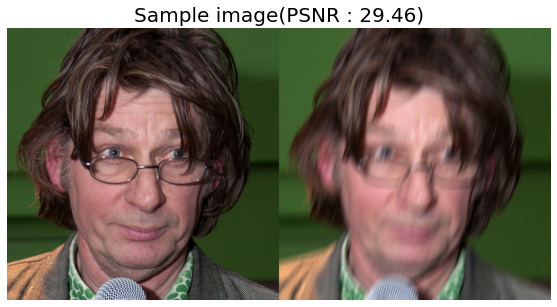

In [42]:
clean_img_sample, _ = face_dataset_clean[58]
blur_img_sample, blur_img_psnr = face_dataset_blur[58]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [43]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [44]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [45]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 1.835146
L2 distance : 0.935125
Cosine similarity : 0.562771


## Sample 9

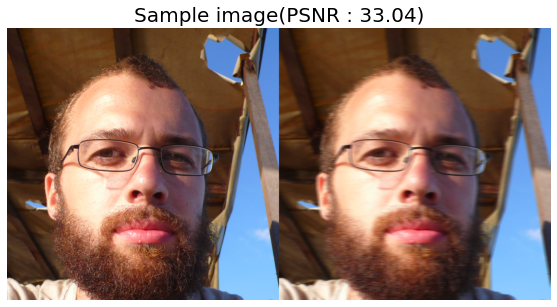

In [46]:
clean_img_sample, _ = face_dataset_clean[203]
blur_img_sample, blur_img_psnr = face_dataset_blur[203]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [47]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [48]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [49]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 0.273357
L2 distance : 0.273990
Cosine similarity : 0.962465


## Sample 10

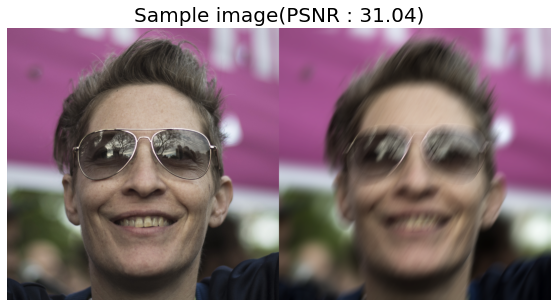

In [50]:
clean_img_sample, _ = face_dataset_clean[245]
blur_img_sample, blur_img_psnr = face_dataset_blur[245]

compare = np.concatenate((clean_img_sample, blur_img_sample), 1)
plt.figure(figsize=(10, 5))
plt.imshow(compare)
plt.title(f"Sample image(PSNR : {blur_img_psnr:.2f})", fontsize=20)
plt.axis('off')
plt.show()

In [51]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()
emb_clean = resnet(torch.Tensor(clean_img_sample).permute(2, 0, 1).unsqueeze(0))
emb_blur = resnet(torch.Tensor(blur_img_sample).permute(2, 0, 1).unsqueeze(0))

In [52]:
L1_dist = L1_distance(emb_clean, emb_blur)
L2_dist = L2_distance(emb_clean, emb_blur)
cossim = cos_sim(emb_clean.squeeze(0).detach().numpy(), emb_blur.squeeze(0).detach().numpy())

In [53]:
print(f'L1 distance : {L1_dist:.6f}')
print(f'L2 distance : {L2_dist:.6f}')
print(f'Cosine similarity : {cossim:.6f}')

L1 distance : 1.895451
L2 distance : 0.893489
Cosine similarity : 0.600839
